Isaac Hus <br>
Personal Research Project <br>
Winter 2024 <br>
MNIST NN Model Stealing <br>

## Import libraries and check for CUDA support

In [58]:
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

After the required libs are imported, check if the gpu on the machine can be used
<br>
This took a long time initially, having to update drivers and download the correct CUDA version.

In [59]:
print('CUDA Version: ',torch.version.cuda)
print('CUDA devices (GPU\'s) found: ',torch.cuda.device_count())
assert(torch.cuda.is_available())

CUDA Version:  11.8
CUDA devices (GPU's) found:  1


## Create NN class

Creation of the NN class. This defines the structure of the model as well as how to step through it using the 'forward' function.

In [60]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # 784 -> 64 -> 64 -> 10
        # 784 is the pixels in the image

        self.l1 = nn.Linear(28 * 28, 64)
        self.l2 = nn.Linear(64,64)
        self.l3 = nn.Linear(64, 10)

        # dropout module with 0.1 drop probability
        # helps in preventing overfitting
        self.do = nn.Dropout(0.1)
    
    def forward(self,x):
        # forward propogation through the network
        h1 = nn.functional.relu(self.l1(x))
        h2 = nn.functional.relu(self.l2(h1))
        do = self.do(h2 + h1)
        logits = self.l3(do)
        return logits
    
# initialize the model
model = Model().cuda()


## Define Optimiser, Loss and Import the Data
### Optimiser: Stocastic Gradient Descent <br>
Common and computationally easy optimiser to minimise loss <br>
Improves on normal GD by adding randomness in the decent stepping, helping possibly avoid local minima.<br>
Learning rate is set as a constant.

In [61]:
optimiser = optim.SGD(model.parameters(), lr=1e-2)

### Loss function: Cross Entropy <br>
Using cross entropy because its a classification problem, and the output is non-binary.<br>
This assigns a value based on the predicted probibility for the correct class.<br>

<img src='./media/log-loss.png'><br>
https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html

In [62]:
loss = nn.CrossEntropyLoss()

### Load in the dataset <br>
I'm using the MNIST dataset that pytourch provides <br>
Also splitting to training and testing sets. <br>
No validation because I am not tuning hyper-params (not the focus of this study).

In [63]:
data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
train, test = random_split(data, [55000, 5000])
training_loader = DataLoader(train, batch_size=32)
test_loader = DataLoader(test, batch_size=32)

## Main Training Loop
Most of the details for the code is in the comments.<br>
The training is done in 5 epochs. After each epoch the test accuracy is printed. <br>
To see better metrics continue to the confusion matrix below.

In [64]:
# go through the data set 5 times
num_epoch = 5
for epoch in range(num_epoch):

  # step through the data set batch by batch
  for batch in training_loader:

    # get the data and labels
    # x is an image
    # y is a label
    x, y = batch

    batch_size = x.size(0)
    x = x.view(batch_size, -1).cuda()

    #1 forward x through model to get logits
    logit = model(x)

    #2 compute loss
    objective = loss(logit, y.cuda())

    #3 cleaning gradient
    model.zero_grad()

    #4 back propagation to compute gradient
    objective.backward()

    #5 apply updates (step down gradients)
    optimiser.step()

  accuracy = []
  # go through the test set and check accuracy
  for batch in test_loader:
    x, y = batch
    batch_size = x.size(0)
    x = x.view(batch_size, -1).cuda()
    with torch.no_grad():
      logit = model(x)
    objective = loss(logit, y.cuda())
    accuracy.append(y.eq(logit.detach().argmax(dim=1).cpu()).float().mean())
  print(f'Epoch {epoch + 1}, validation accuracy: {torch.tensor(accuracy).mean():.2f}')


Epoch 1, validation accuracy: 0.87
Epoch 2, validation accuracy: 0.90
Epoch 3, validation accuracy: 0.91
Epoch 4, validation accuracy: 0.92
Epoch 5, validation accuracy: 0.93


### save the model to a .pth file for use by the shadow model

In [65]:
torch.save(model.state_dict(), 'target.pth')

## Target Model Metrics<br>
Performance metrics for the model.

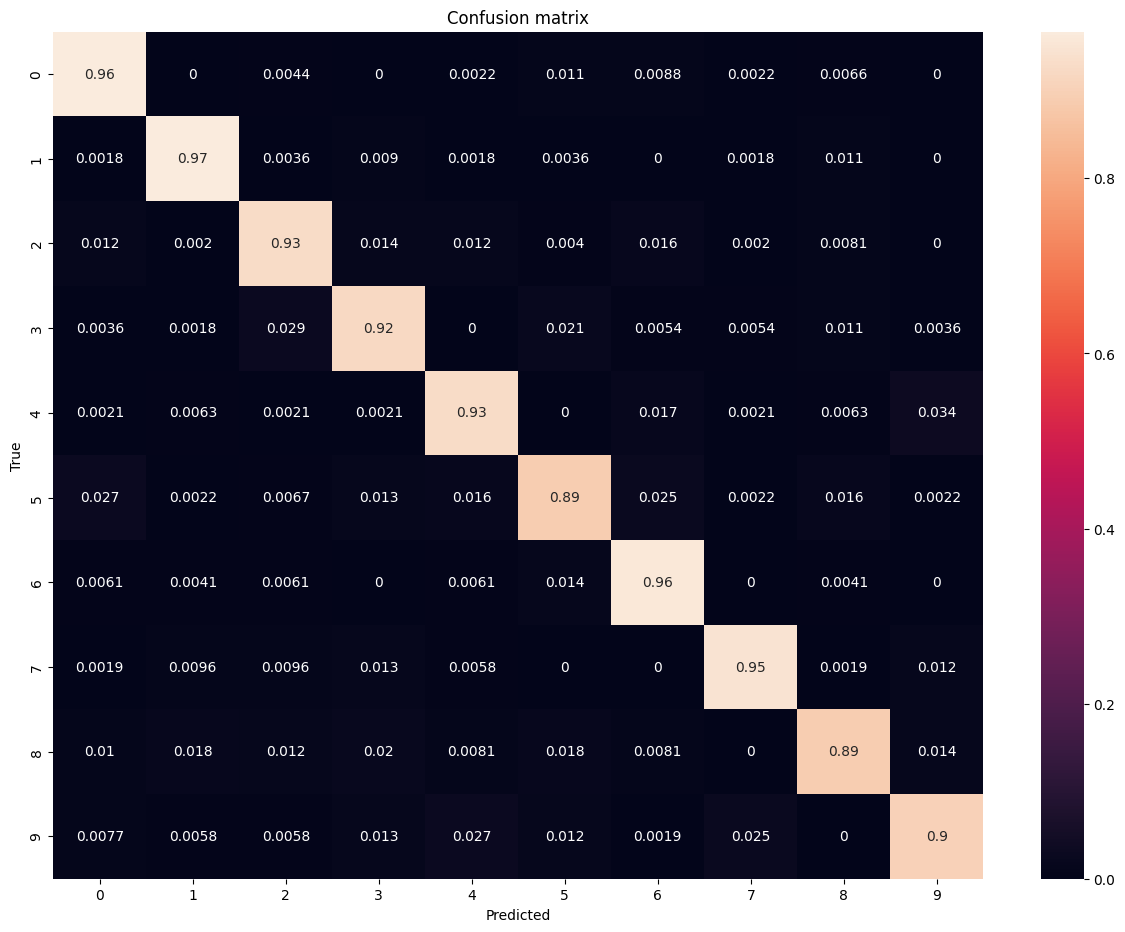

Overall accuracy: 93.00%


In [66]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np

y_pred = []
y_true = []
for batch in test_loader:
        x, y = batch
        batch_size = x.size(0)
        x = x.view(batch_size, -1).cuda()
        with torch.no_grad():
          logit = model(x)

        output = (torch.max(torch.exp(logit), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)
        
        y = y.data.cpu().numpy()
        y_true.extend(y)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm / np.sum(cm, axis=1)[:, None], index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (15,11))
plt.title('Confusion matrix')
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print('Overall accuracy: {:.2f}'.format((np.trace(cm) / np.sum(cm)) * 100) + '%')